<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Ship Images Classification


### Import Libary

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2
import os
import gc
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split
from keras_preprocessing.image import load_img, img_to_array, array_to_img ,ImageDataGenerator
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D , GlobalAveragePooling2D
from keras.optimizers import Adam , RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import tensorflow as tf

from keras import callbacks
from keras.callbacks import ModelCheckpoint, LearningRateScheduler , EarlyStopping ,TensorBoard
from keras import optimizers 
from keras.models import load_model

from keras.applications.xception import Xception
#from keras.applications import VGG16
from keras.applications.vgg16 import VGG16, preprocess_input

from livelossplot import PlotLossesKeras

In [2]:
import warnings
warnings.filterwarnings('ignore')
print(os.listdir("../input"))

from numpy.random import seed
seed(2019)
#from tensorflow import set_random_seed
import tensorflow
tensorflow.random.set_seed(2019)

['.ipynb_checkpoints', 'download', 'sample_submission_ns2btKE.csv', 'test.csv', 'train']


Set up local GPU to run tensorflow

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Import images file

In [5]:
path = "../input/train/images"

train_files = pd.read_csv('../input/train/train.csv', 
                          dtype={'image': 'object', 'category': 'int8'})

test_files = pd.read_csv('../input/test.csv')

In [6]:
train_files.head(20)

image  category
0   2823080.jpg         1
1   2870024.jpg         1
2   2662125.jpg         2
3   2900420.jpg         3
4   2804883.jpg         2
5    621252.jpg         4
6   2833467.jpg         1
7   2843780.jpg         5
8   2859567.jpg         3
9   2896557.jpg         1
10  2847618.jpg         3
11  2874678.jpg         3
12  2903279.jpg         3
13  2892401.jpg         1
14  2891158.jpg         2
15  2896519.jpg         5
16  2870078.jpg         1
17  2845743.jpg         5
18  2692646.jpg         2
19  2839660.jpg         5

Check for missing categories in train

In [7]:
# display missing categories in train
train_files[train_files.isnull().any(axis=1)]

Empty DataFrame
Columns: [image, category]
Index: []

No missing values found

In [8]:
# dictionary ship encoding 
ship = {'Cargo': 1, 
        'Military': 2, 
        'Carrier': 3, 
        'Cruise': 4, 
        'Tankers': 5}

# reverse the ship type dictionary
ship = dict([[v,k] for k,v in ship.items()])

In [9]:
ship

{1: 'Cargo', 2: 'Military', 3: 'Carrier', 4: 'Cruise', 5: 'Tankers'}

In [10]:
# Create test labels for interpretability
train_files['ship'] = train_files['category'].map(ship).astype('category')
labels = list(train_files['ship'].unique())

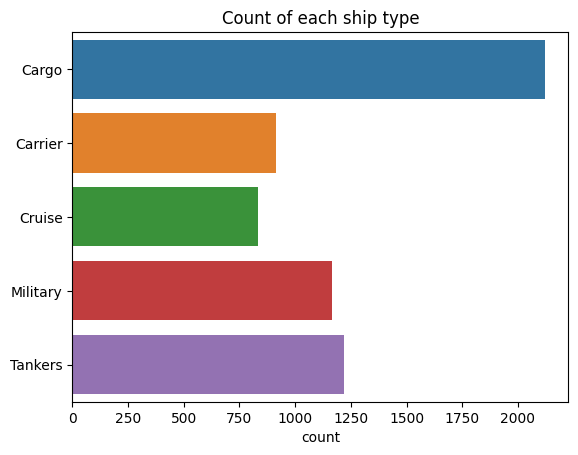

3479

In [11]:
# display count of ship types
plt.title('Count of each ship type')
sns.countplot(y=train_files['ship'].values)
plt.show()
gc.collect()

In [12]:
train_files['ship'].value_counts(normalize=False)

ship
Cargo       2120
Tankers     1217
Military    1167
Carrier      916
Cruise       832
Name: count, dtype: int64

In [13]:
train_files['ship'].value_counts(normalize=True)

ship
Cargo       0.339091
Tankers     0.194658
Military    0.186660
Carrier     0.146513
Cruise      0.133077
Name: proportion, dtype: float64

There are class imbalances in training set,we can see that Cargo ship have 33 percent of the data set while Cruise only have 13percent. 
Therefor will create a confusion matrix visualize to found out which catergory in the neural network classifier is having trouble.
Will also stratify train_test_split in order to maintain the class distributions in both train and test.

### Encode Train lable

In [14]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(dtype='int8', sparse=False)
y_train = ohe.fit_transform(train_files['category'].values.reshape(-1,1))

### Load Train/Test Files

In [15]:
# Since most pre-trained models have a specific input dimension,
# we will need to set the target_size to match the pre-trained model input shape.
# Increasing shape of the images requires more RAM.
def load(what='train', target_size=(224,224)):
    array = []
    if what =='train':
        for file in tqdm(train_files['image'].values):
            img = load_img(os.path.join(path, file), target_size=target_size)
            img = img_to_array(img)/255. # normalize image tensor
            array.append(img)
    elif what =='test':
        for file in tqdm(test_files['image'].values):
            img = load_img(os.path.join(path, file), target_size=target_size)
            img = img_to_array(img)/255. # normalize image tensor
            array.append(img)
    gc.collect()
    return np.asarray(array)

In [16]:
# Load Train and Test
X_train = load()
test = load('test')
print(f'train dtype: {X_train.dtype}')
print(f'test dtype: {test.dtype}')
print(f'train shape: {X_train.shape}')
print(f'test shape: {test.shape}')

100%|██████████| 2680/2680 [00:01<00:00, 1402.49it/s]


train dtype: float32
test dtype: float32
train shape: (6252, 224, 224, 3)
test shape: (2680, 224, 224, 3)


In [17]:
train_files

image  category      ship
0     2823080.jpg         1     Cargo
1     2870024.jpg         1     Cargo
2     2662125.jpg         2  Military
3     2900420.jpg         3   Carrier
4     2804883.jpg         2  Military
...           ...       ...       ...
6247  2881056.jpg         3   Carrier
6248  1145083.jpg         2  Military
6249  2898652.jpg         5   Tankers
6250  2868175.jpg         3   Carrier
6251  2784171.jpg         1     Cargo

[6252 rows x 3 columns]

In [18]:
test_files

image
0     1007700.jpg
1     1011369.jpg
2     1051155.jpg
3     1062001.jpg
4     1069397.jpg
...           ...
2675   950995.jpg
2676   951046.jpg
2677   951323.jpg
2678   952113.jpg
2679   953982.jpg

[2680 rows x 1 columns]

### View Some Train Images

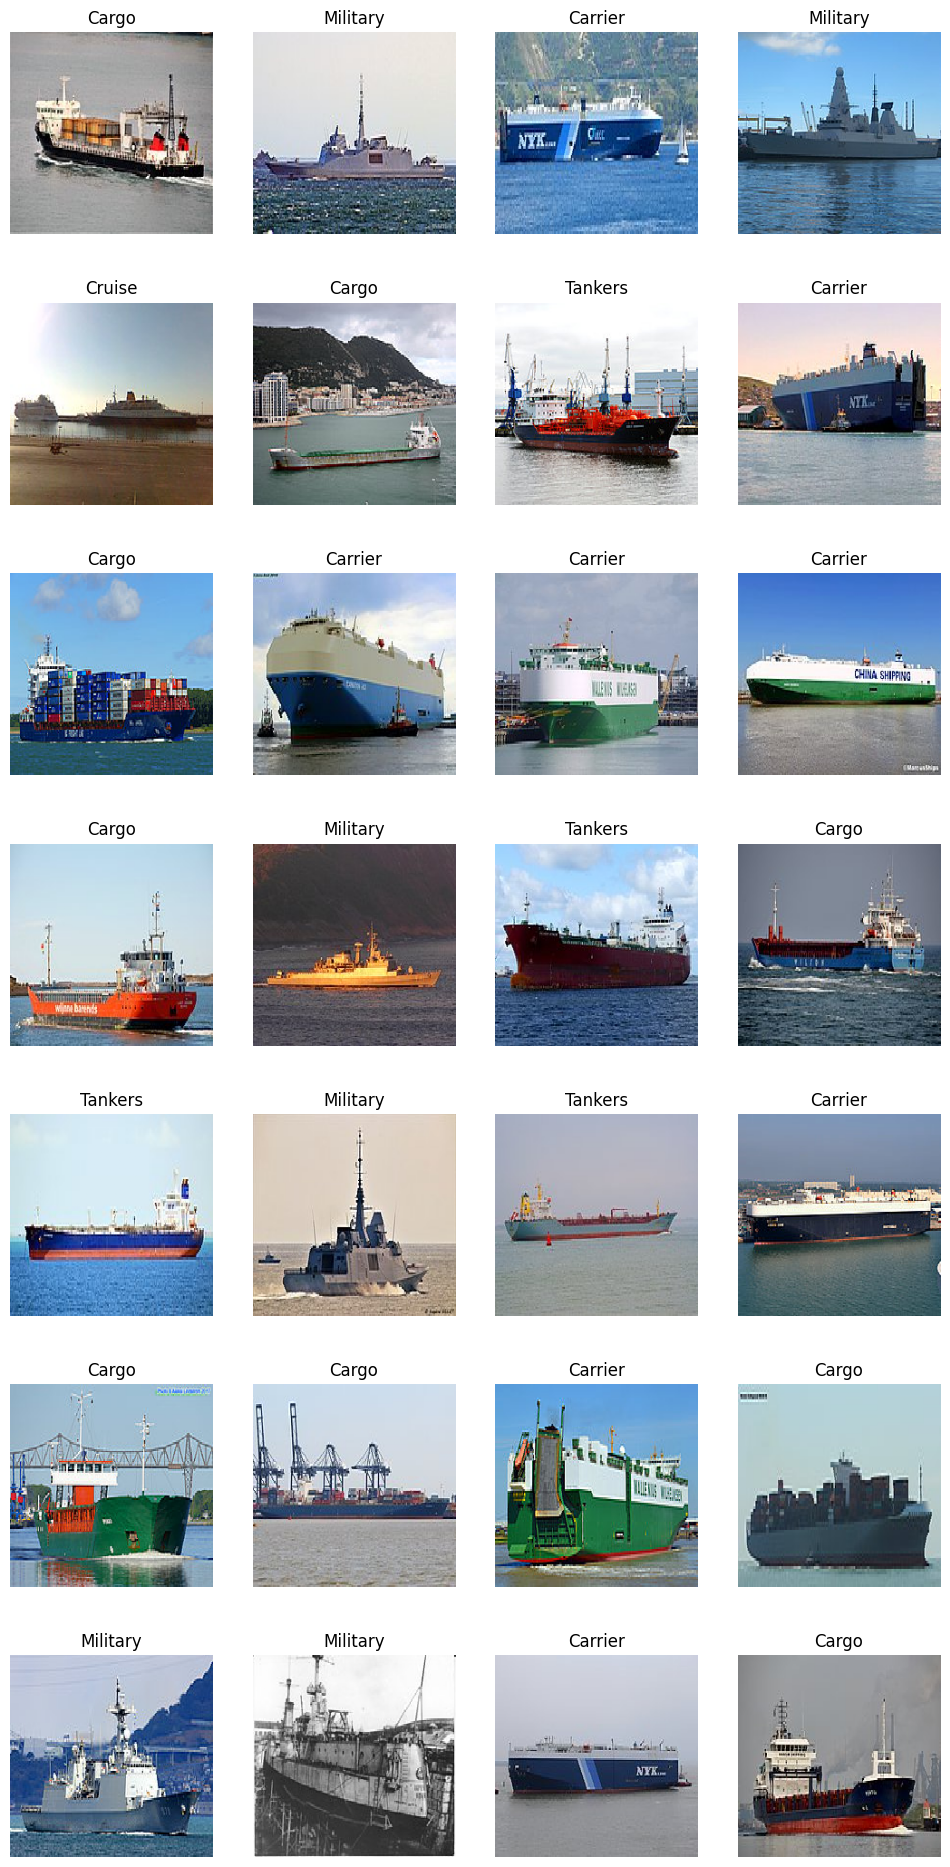

67890

In [19]:
# visualize the top 28 train images
plt.figure(figsize=(12,24))

for i in range(1,29):
    plt.subplot(7,4,i)
    plt.title(f'{train_files["ship"].values[i]}')
    plt.imshow(X_train[i])
    plt.axis('off')
plt.show()
gc.collect()

### View Some Test Images

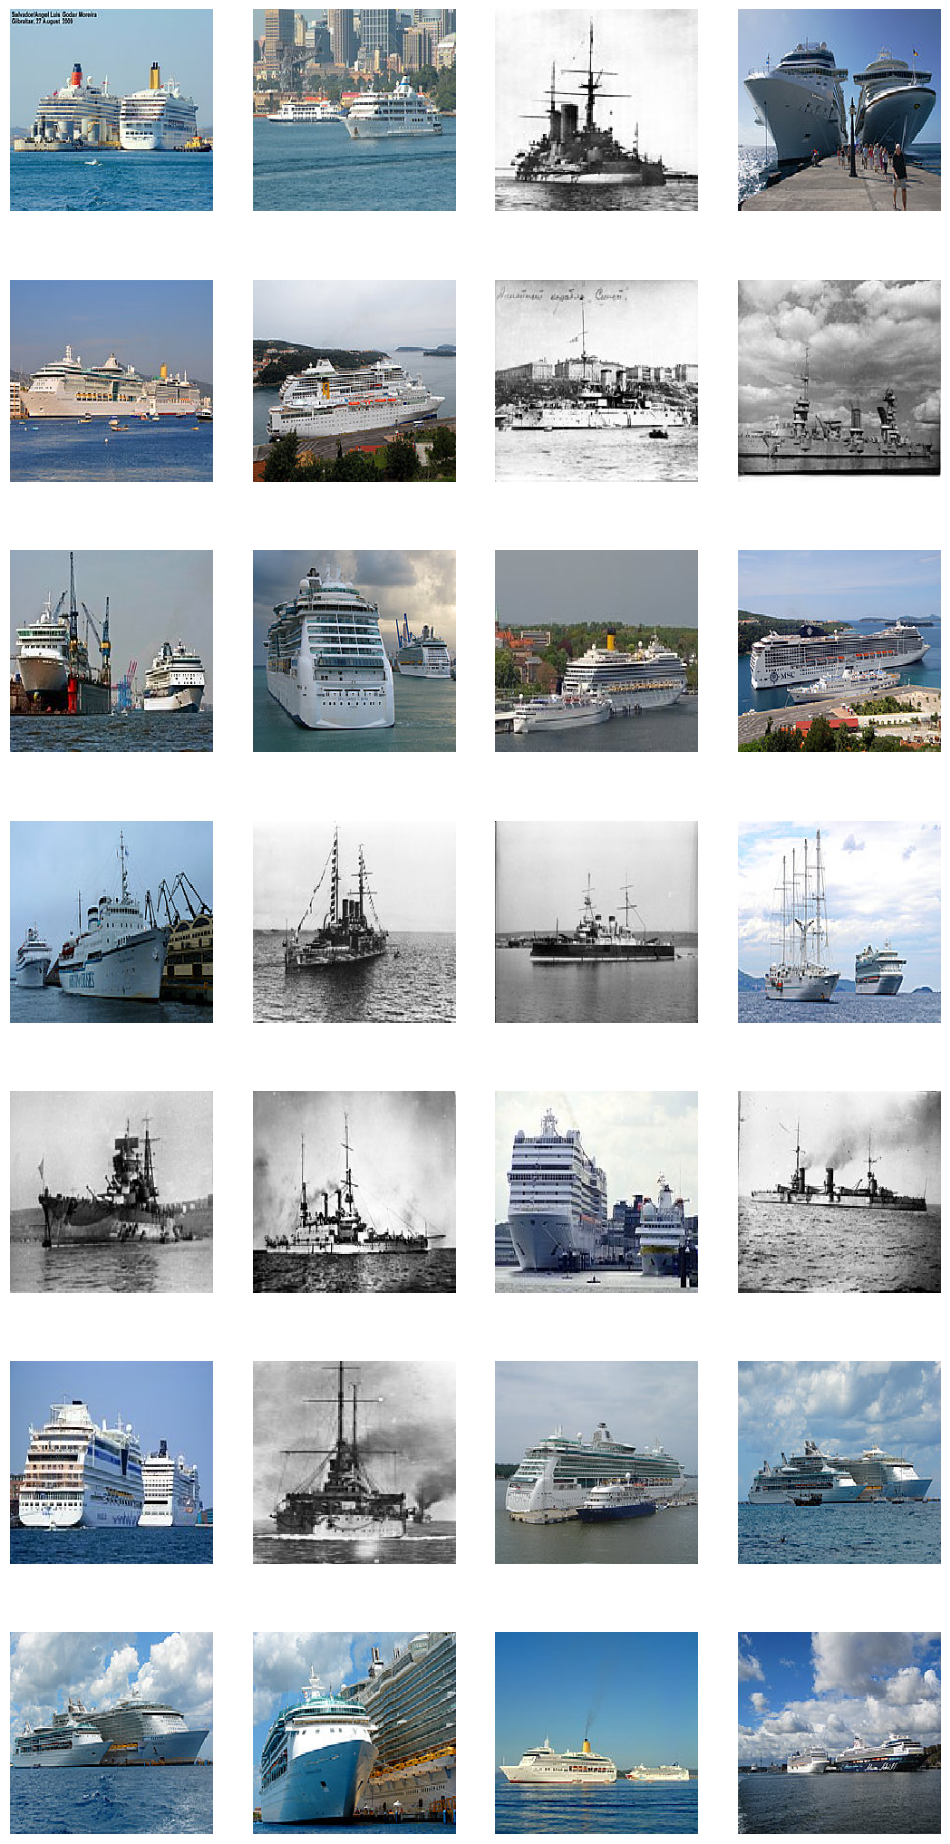

54939

In [20]:
# visualize the top 28 test images
plt.figure(figsize=(12,24))

for i in range(1,29):
    plt.subplot(7,4,i)
    plt.imshow(test[i])
    plt.axis('off')
plt.show()
test # free up space for training
gc.collect()

There are black and white images mixed in with color images. Some images are old. Some images contain steam/smoke coming out of the smokestacks. Some images contain multiple ships. Some contain clouds and others contain various background scenery. Some contain a lengthwise display and others contain a display of the front of head of a ship. Some images are low contrast.

In order to address some of these concerns, such as grayscale, rotation, noise, etc. We will need to perform data augmentation to create a more robust training set for our Neural Network to learn from. This may help better generalize into testing dataset as well as help the network from overfitting to some extent.

### Split the data from train to train and test set

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, 
                                                    stratify=y_train,
                                                    random_state=2019,
                                                    test_size=0.2)

In [22]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
gc.collect()

(5001, 224, 224, 3)
(1251, 224, 224, 3)
(5001, 5)
(1251, 5)


0

It is crucial to modify (augment) the existing image dataset through the use of a data generator. Data augmentation may hurt or improve model performance so care must be taken at this step. Data augmentation needs to be considered case-by-case. So adding a vertical flip when none of the ships are flipped upside-down will likely decrease model generaliziblity to testing data.

Adaptive learning rates can help models converge to the optimal solution much better.

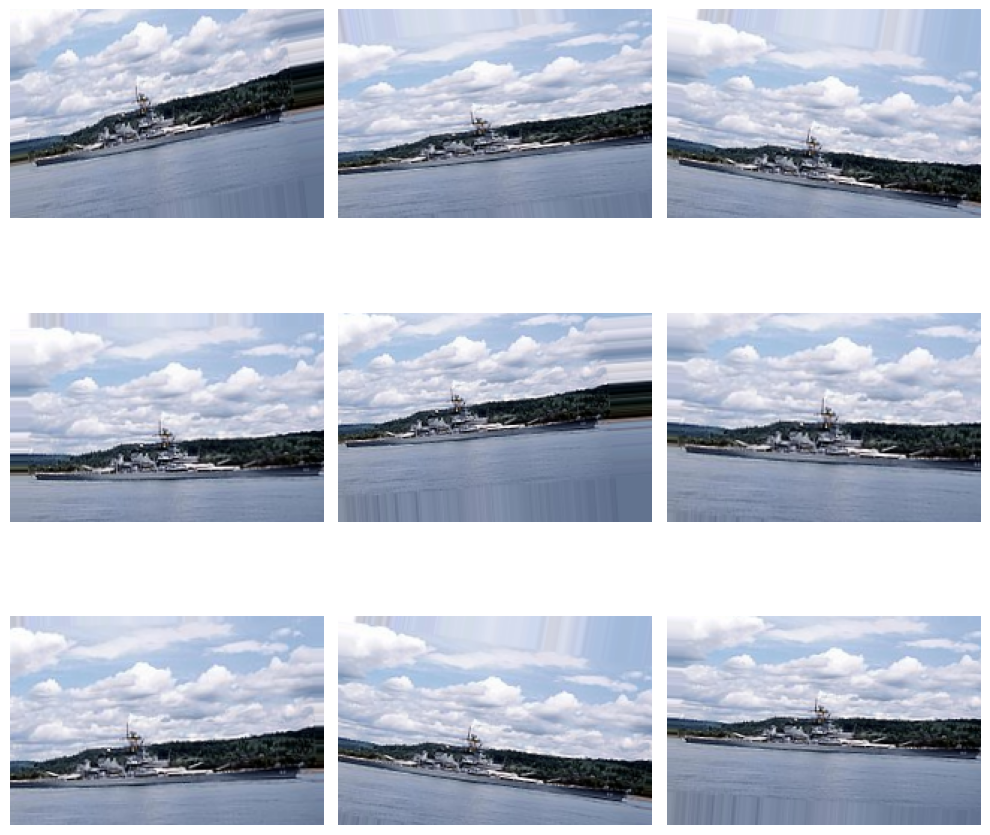

In [23]:
datagen = ImageDataGenerator(
    rotation_range=10,  # Random rotation between -10 and +10 degrees
    width_shift_range=0.1,  # Random shift horizontally by 10% of the image width
    height_shift_range=0.1,  # Random shift vertically by 10% of the image height
    shear_range=0.2,  # Shear the image by 20% randomly
    zoom_range=0.2,  # Randomly zoom the image by 20%
    horizontal_flip=False,  # Do not flip the image horizontally
    fill_mode='nearest'  # Fill any newly created pixels during augmentation with the nearest available pixel
)


# Load and augment a sample image
image_path = '../input/train/images/1333616.jpg'
image = plt.imread(image_path)
image = image.reshape((1,) + image.shape)  # Reshape the image to match the expected input shape of the data generator

# Generate augmented images
augmented_images = datagen.flow(image, batch_size=1)

# Display augmented images
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

for i in range(3):
    for j in range(3):
        augmented_image = augmented_images.next()[0].astype('uint8')  # Retrieve the next augmented image
        axs[i, j].imshow(augmented_image)
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()




### Create a Baseline model without Pre-train Data.

In [31]:
model = Sequential()
model.add(Conv2D(20, kernel_size=(3, 3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

#Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

# Define the data generators for training and validation data
datagen = ImageDataGenerator(
    rotation_range=10,  # Random rotation between -10 and +10 degrees
    width_shift_range=0.1,  # Random shift horizontally by 10% of the image width
    height_shift_range=0.1,  # Random shift vertically by 10% of the image height
    shear_range=0.2,  # Shear the image by 20% randomly
    zoom_range=0.2,  # Randomly zoom the image by 20%
    horizontal_flip=False,  # Do not flip the image horizontally
    fill_mode='nearest'  # Fill any newly created pixels during augmentation with the nearest available pixel
)

datagen.fit(X_train, augment=True, rounds=1, seed=2019)
train_generator = datagen.flow(X_train,y_train, batch_size=6 ,seed=2019)




# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')


Epoch 1/100
834/834 [==============================] - ETA: 0s - loss: 1.4326 - accuracy: 0.3847
Epoch 1: val_loss improved from inf to 1.24168, saving model to img_model2.weights.best.hdf5
834/834 [==============================] - 43s 50ms/step - loss: 1.4326 - accuracy: 0.3847 - val_loss: 1.2417 - val_accuracy: 0.4740
Epoch 2/100
834/834 [==============================] - ETA: 0s - loss: 1.2081 - accuracy: 0.4839
Epoch 2: val_loss improved from 1.24168 to 1.05471, saving model to img_model2.weights.best.hdf5
834/834 [==============================] - 72s 86ms/step - loss: 1.2081 - accuracy: 0.4839 - val_loss: 1.0547 - val_accuracy: 0.6251
Epoch 3/100
833/834 [============================>.] - ETA: 0s - loss: 1.0473 - accuracy: 0.5546
Epoch 3: val_loss improved from 1.05471 to 0.86697, saving model to img_model2.weights.best.hdf5
834/834 [==============================] - 48s 57ms/step - loss: 1.0468 - accuracy: 0.5547 - val_loss: 0.8670 - val_accuracy: 0.6603
Epoch 4/100
834/834 [==

In [25]:
model = Sequential()
model.add(Conv2D(20, kernel_size=(3, 3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

#Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

# Define the data generators for training and validation data
datagen = ImageDataGenerator(
    rotation_range=10,  # Random rotation between -10 and +10 degrees
    width_shift_range=0.1,  # Random shift horizontally by 10% of the image width
    height_shift_range=0.1,  # Random shift vertically by 10% of the image height
    shear_range=0.2,  # Shear the image by 20% randomly
    zoom_range=0.2,  # Randomly zoom the image by 20%
    horizontal_flip=False,  # Do not flip the image horizontally
    fill_mode='nearest'  # Fill any newly created pixels during augmentation with the nearest available pixel
)

datagen.fit(X_train, augment=True, rounds=1, seed=2019)
train_generator = datagen.flow(X_train,y_train, batch_size=6 ,seed=2019)




# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')



# Fit model on training data.
n_epochs=100
history = model.fit_generator(generator=train_generator, 
                    validation_data=(X_test, y_test),
                    epochs=n_epochs,
                    callbacks=[early_stop,checkpointer],
                    verbose=1)

Epoch 1/100
834/834 [==============================] - ETA: 0s - loss: 1.4207 - accuracy: 0.4103
Epoch 1: val_loss improved from inf to 1.12470, saving model to img_model.weights.best.hdf5
834/834 [==============================] - 47s 55ms/step - loss: 1.4207 - accuracy: 0.4103 - val_loss: 1.1247 - val_accuracy: 0.5308
Epoch 2/100
833/834 [============================>.] - ETA: 0s - loss: 1.1826 - accuracy: 0.5111
Epoch 2: val_loss improved from 1.12470 to 1.03680, saving model to img_model.weights.best.hdf5
834/834 [==============================] - 47s 57ms/step - loss: 1.1830 - accuracy: 0.5107 - val_loss: 1.0368 - val_accuracy: 0.5803
Epoch 3/100
833/834 [============================>.] - ETA: 0s - loss: 1.1054 - accuracy: 0.5518
Epoch 3: val_loss improved from 1.03680 to 1.01254, saving model to img_model.weights.best.hdf5
834/834 [==============================] - 48s 58ms/step - loss: 1.1049 - accuracy: 0.5517 - val_loss: 1.0125 - val_accuracy: 0.6083
Epoch 4/100
834/834 [=====

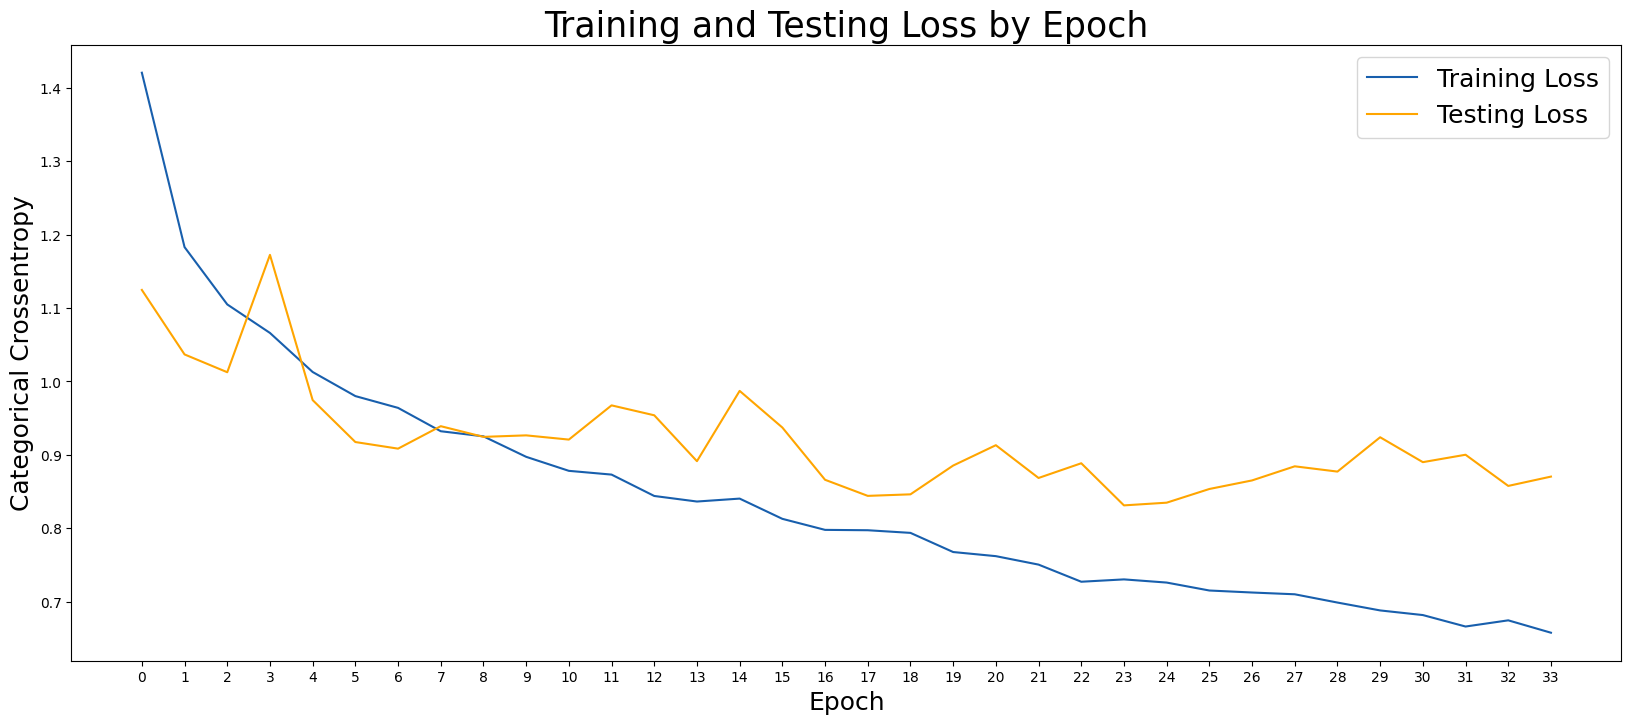

In [26]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_labels = history.epoch

# Set figure size.
plt.figure(figsize=(20, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

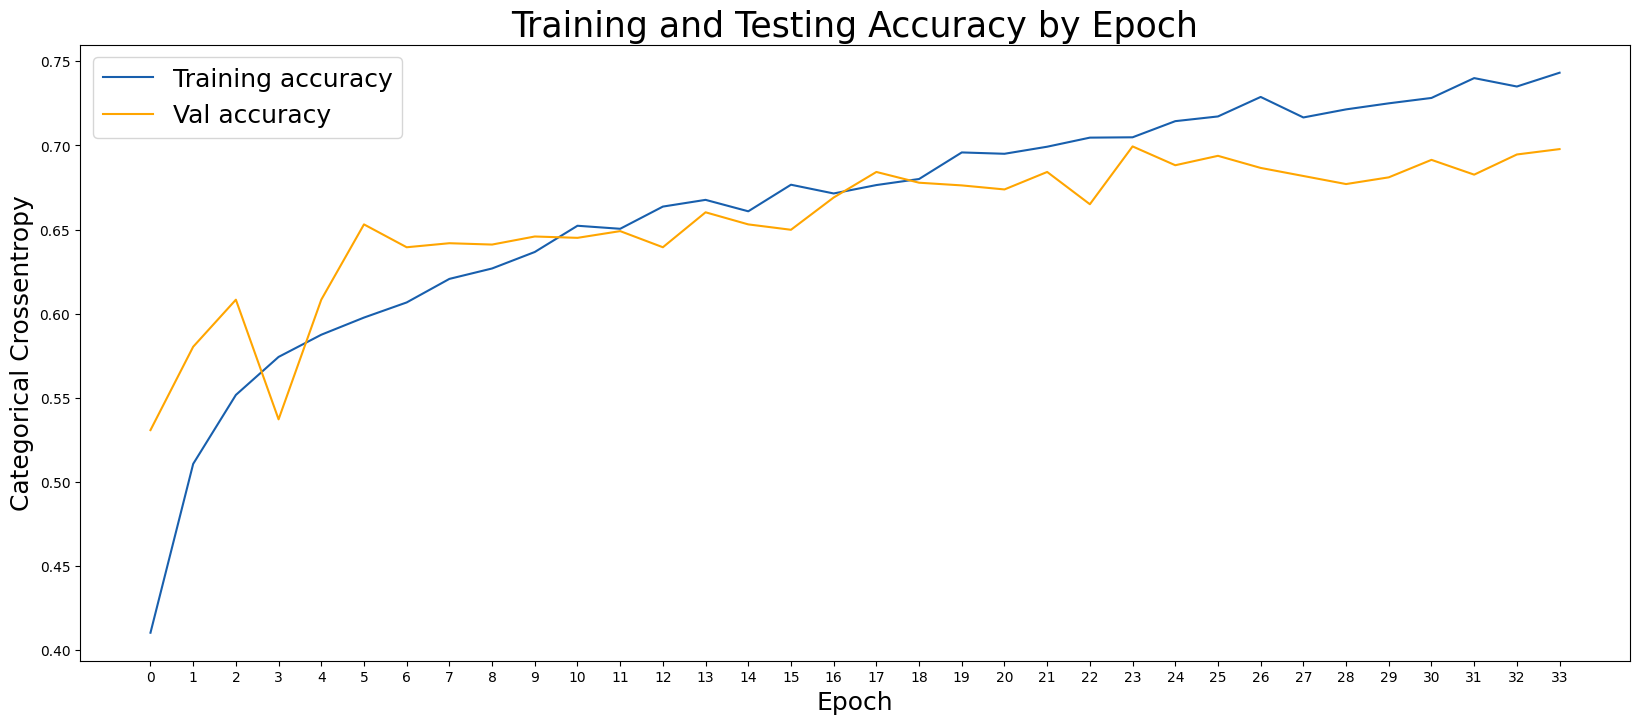

In [27]:
# Check out our train loss and test loss over epochs.
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epoch_labels = history.epoch

# Set figure size.
plt.figure(figsize=(20, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(accuracy, label='Training accuracy', color='#185fad')
plt.plot(val_accuracy, label='Val accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

From this model the we can see that the early stopping have stop the model from training as the val loss is increase after 34 epoch.

This indicates that the model is overfitting, and cannot generalize on new data. In particular, the model performs well on training data but poorly on validation set. At a point, the validation loss decreases but starts to increase again.

accuracy for this model is also very low at 54perenct

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 20)      560       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 20)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 246420)            0         
                                                                 
 dense (Dense)               (None, 256)               63083776  
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 63,085,621
Trainable params: 63,085,621
Non-trainable params: 0
____________________________________________

In [ ]:
true = np.argmax(y_test, axis=1)

valid_pred = np.argmax(model.predict(X_test), axis=1)

40/40 [==============================] - 1s 18ms/step


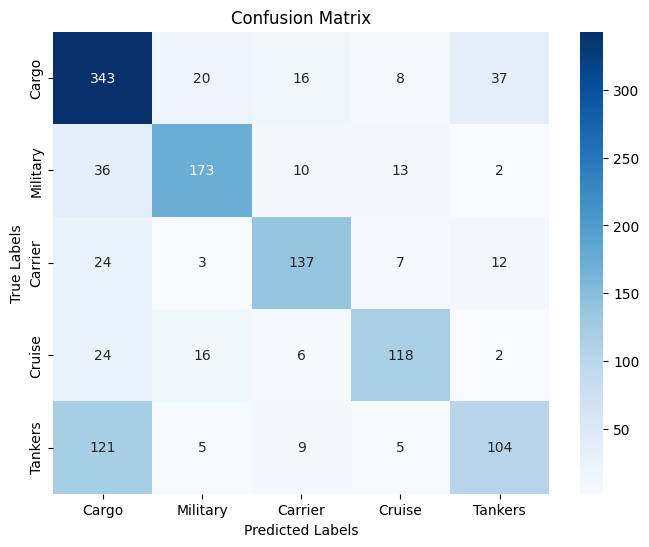

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.81      0.71       424
           1       0.80      0.74      0.77       234
           2       0.77      0.75      0.76       183
           3       0.78      0.71      0.74       166
           4       0.66      0.43      0.52       244

    accuracy                           0.70      1251
   macro avg       0.73      0.69      0.70      1251
weighted avg       0.71      0.70      0.69      1251



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


# Compute the confusion matrix
cm = confusion_matrix(true, valid_pred)


# Define class labels
class_labels = ["Cargo", "Military", "Carrier", "Cruise","Tankers"]  # Replace with your actual class labels

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Set labels, title, and ticks
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

# Display the plot
plt.show()

# Compute and print classification report
print("Classification Report:")
print(classification_report(true, valid_pred))
